# Exercise 01
## Histogram of Orientated Gradients

Even though nowadays there exist much better working object detectors than Histogram of Oriented Gradients, the historic approach was one of the first attempts to build feature descriptors, which encode the image with lower spatial and higher feature dimension in order to solve the matching problem.

## Imports

This will setup your whole environment such that you can work with the rest of the notebook.

### General Imports

In [1]:
from pathlib import Path
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

/home2/yehia.ahmed/SafeML_2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up directory paths and (optionally) mount in Google Colab
If you work with google colab set the `USING_COLAB` variable to `True` and following cell to mount your gdrive.

In [2]:
USING_COLAB = False
USE_CPU = True
# Use the following lines if you want to use Google Colab
# We presume you created a folder "cv3dst" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_03) is given.

if USING_COLAB:
    from google.colab import drive
    import os

    gdrive_path='/content/gdrive/MyDrive/cv3dst/exercise_01'

    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Check manually if all files are present
    print(sorted(os.listdir()))
    root_dir = Path(gdrive_path).parent
else:
    root_dir = Path('/home2/yehia.ahmed/cv3/cv3dst')
    # root_dir = Path('/storage/remote/adm9/cv3dst/cv3ws23/cv3_exercises/cv3dst')
dataset_dir = root_dir.joinpath("datasets")
output_dir = root_dir.joinpath('exercise_01', 'models')
output_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda') if torch.cuda.is_available() and not USE_CPU else torch.device('cpu')

### Exercise Specific Imports

In [3]:
from exercise_code.test import (
    test_compute_iou,
    test_fill_hog_bins,
    test_compute_image_gradient,
    test_sliding_window_detection,
    test_non_maximum_suppression,
)
from exercise_code import (
    compute_image_gradient,
    fill_hog_bins,
    non_maximum_suppression,
    MOT16HoG,
    obj_detect_transforms,
    train,
    evaluate,
    Net,
    visualization,
    sliding_window_detection,
    extract_bbox_from_heatmap,
    blockify_tensor,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Exercise Part I - Loading the dataset

In this exercise we will be working with the [MOT16](https://arxiv.org/abs/1603.00831) [1] dataset for multi-object tracking. Originally designed for people tracking - something you will deal with in the upcoming exercises -, we will use this dataset in this exercise for people detection. The dataset provides video sequences of images with multiple people. It also provides the bounding box annotations for people that we use as positiv examples in our training with the HOG features. However, the dataset does not provide negative examples that we need for our training scheme. 

In this exercise, we will create our own negative examples selecting random patches in the image. Naively sampling the image will not work, as there is a chance we sample an image patch with a person inside. In order to avoid this, we need to calculate the overlap of our random patch with all the positive examples. We do this by calculating the `Intersection over Union (IoU)` or `Jaccard Index` of two bounding boxes $A$ and $B$ defined as

$$ J(A, B) = \frac{A \cap B}{A \cup B}$$

<div class="alert alert-info">
    <h3>Task: IoU</h3>
    <p>
    Go to <code>exercise_code/model/compute_iou.py</code> and complete the <code>compute_iou</code> function. Be aware of the input shapes of the IoU function. We expect the function to compute the IoU between two batches of bounding boxes. The instruction in the code explain the input and output shapes in more detail.
    </p>
</div>

<div class="alert alert-danger">
    <h3>Test: IoU</h3>
    <p> Run the following cell to execute the test case for the IoU. As always the test are done with small dummy examples and do <b>not</b> guarantee correct implementation.</p>
</div>

In [20]:
_ = test_compute_iou()

Congratulations: The output shape of compute_iou is correct
Congratulations: The output range of compute_iou is correct
Congratulations: The output shape of compute_iou is symmetrical
Congratulations: Test case 1 ran successfully
Congratulations: Test case 1 ran successfully
Congratulations: Test case 1 ran successfully
Congratulations: Test case 1 ran successfully
All tests of IoUTest passed. Tests passed: 7/7
Score: 100/100


In [5]:
dataset_dir.joinpath("MOT16", "train")

PosixPath('/home2/yehia.ahmed/cv3/cv3dst/datasets/MOT16/train')


<p> For training our object detector, we need a dataset containing positive and negative samples (object/no object). The MOT dataset containes bounding box annotations around people, which serve as positive samples. We extended this dataset by adding negative samples for each image, filling the number of bounding boxes until <code>num_patches=50</code> for each image. The negatively labeled bounding boxes are randomly chosen with the constrain that its overlap with any positive bounding box annotation is smaller than <code>neg_th</code>.

</p>

In [6]:
dataset_train = MOT16HoG(dataset_dir.joinpath("MOT16", "train"), transforms=obj_detect_transforms(train=False))
dataset_test = MOT16HoG(dataset_dir.joinpath("MOT16", "test"), random_offset=False, transforms=obj_detect_transforms(train=False))


If loaded correctly, the length of the datasets should be:

`3729 1587`


In [7]:
print(len(dataset_train))
print(len(dataset_test))

3729
1587


### Visualizing examples of the dataset

We visualize one sample of the dataset by displaying all 50 bounding box/patch annotations. The red frame indicates that the patch is labeled as negative, whereas the green frame is used for positive annotations.

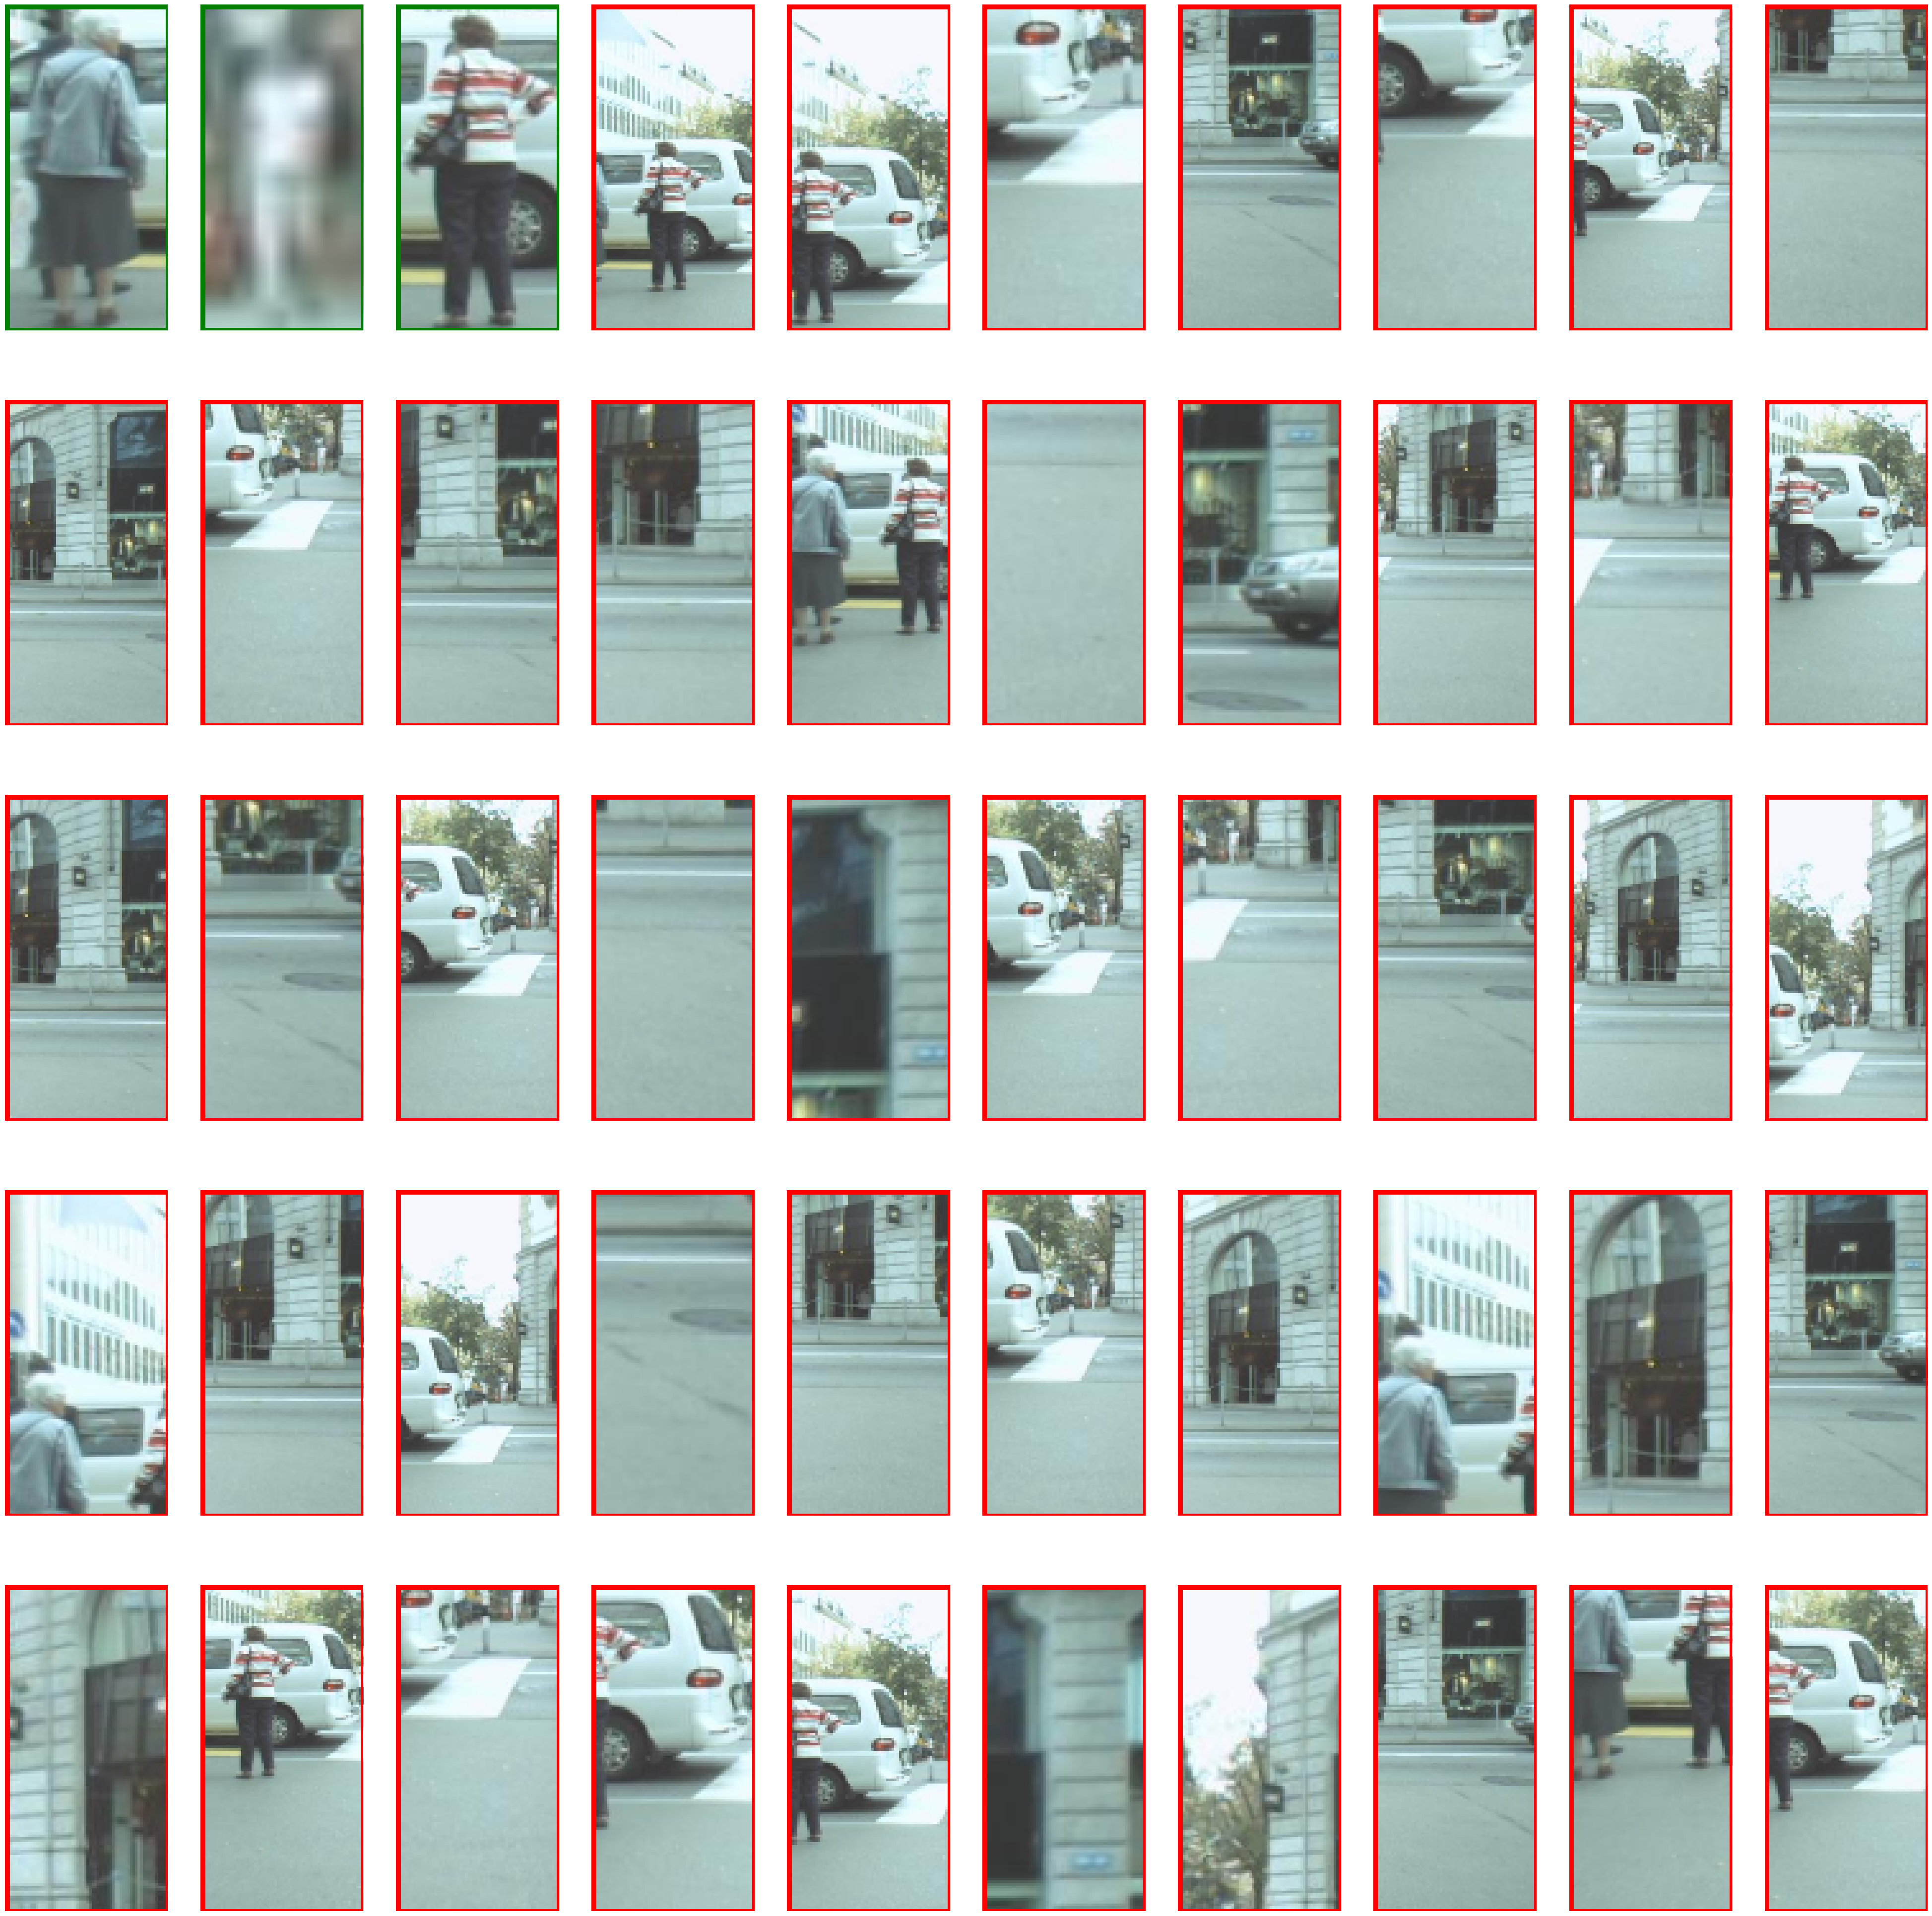

In [8]:
img, target = dataset_test[0]

rows, cols = 5, 10

visualization.dataset(target["patches"], target["patch_labels"], rows, cols)

## Exercise Part II - Oriented Gradients

Next up, we need to calculate the gradients of the image. We want to know both the magnitude as well as the orientation of the gradients at each pixel location. For this exercise, we use the central difference algorithm to calculate the gradient. You can choose other methods as well, but these are not checked by the test cases. With central differences the gradients at pixel location (x, y) are given by

$$\nabla_x I(x, y) = I(x + 1, y) - I(x - 1, y)\,\text{and}$$
$$\nabla_y I(x, y) = I(x, y + 1) - I(x, y - 1)\,.$$

Be aware of the coordinate conventions of the image and the order of rows/columns of pytorch tensors.

From these gradients, we can calculate the norm/magnitude and orientation/angle of the gradients with
$$\nabla_n I(x, y) = \left\| \begin{pmatrix} \nabla_x I(x, y) \\ \nabla_y I(x, y) \end{pmatrix} \right\|_2\,\text{and}$$
$$\nabla_a I(x, y) = \arctan \frac{\nabla_x I(x, y)}{\nabla_y I(x, y)}\,.$$

Of course, the angle is only defined if $$\nabla_y I(x, y) \neq 0$$. Usually there are standard implementations that are able to deal with all these cases. See, if you can find them in pytorch.

<div class="alert alert-info">
    <h3>Task: Orientated Gradients</h3>
    <p> Go to <code>exercise_code/model/compute_image_gradients.py</code> and implement <code>compute_image_gradient</code> for a batch of images. The function returns the norm and orientation of the gradient for each pixel. The gradients will be needed to later compute a histogram for a certain image patch. </p> 
</div>

<div class="alert alert-danger">
    <h3>Test: Orientated Gradients</h3>
    <p> Run the following cell to execute the test case for the Orientated Gradients. <b>Note:</b> This test checks the implementations of the gradients using <b>central difference</b>. As always the test are done with small dummy examples and do <b>not</b> guarantee correct implementation.</p>
</div>

In [9]:
_ = test_compute_image_gradient()

Congratulations: The output shape of compute_image_gradient is correct
torch.Size([3, 128, 64])
Congratulations: Gradient computation is correct
All tests of ImageGradientTest passed. Tests passed: 2/2
Score: 100/100


### Visualizing the Gradients
Additionally to the test cases, you can also check your implementations of the gradient calculation by running the following code cells. They visualize the gradient norm and the gradient orientation.

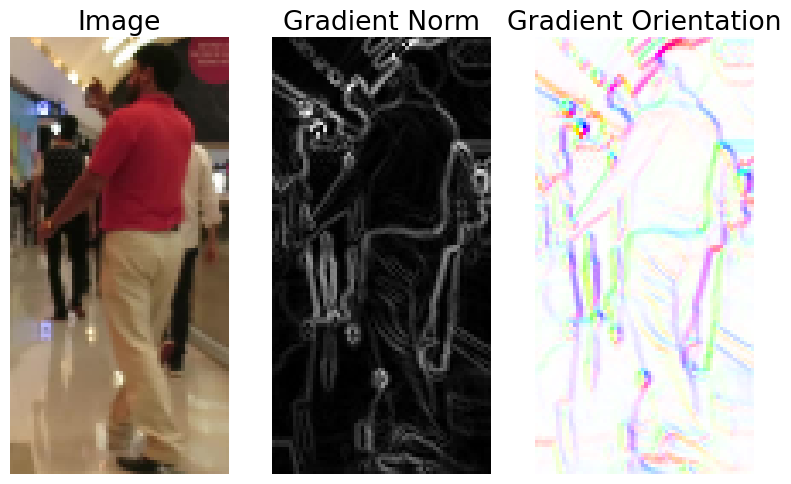

In [10]:
idx = 2829
patch_idx = 0

img = dataset_train[idx][1]["patches"][patch_idx]

gradient_norm, gradient_orientation = compute_image_gradient(transforms.functional.rgb_to_grayscale(img))
visualization.gradients(img, gradient_norm.squeeze(-3), gradient_orientation.squeeze(-3))

For the first example in the dataset (`idx=0,patch_idx=0`), the visualization should look something like this:

![Example Visualization](./gradient_visualization.png)

## Exercise Part III - Histogram of Orientated Gradients

Building a histogram over oriented gradients was one of the first attempts to decrease the spatial dimension while increasing the feature dimension. The first methods defined a certain cell size, containing $N \times M$ (usually $8 \times 8$) pixels. For each of these cells in an image, they build a histogram of the preciously computed gradient orientation and norm. 

The historgram consits of $K$ bins that quantize the angle values of the gradients into equally spaced regions of size $180 / K$ degrees. Now each pixel contributes to this histogram based on its orientation and magnitude. First the two closest bins need to be identified based on the starting angle value they represent. E.g. if $K=9$, then a gradient with an angle of $15$ degrees would contribute to bins $0$ $[0\ldots20)$ degrees and $1$ $[20\ldots40)$ degrees as it is between $0$ and $20$ degrees. 

$$ \nabla_n I(x,y) \frac{\text{width} - d}{\text{width}}$$

is added to the bins based on the distance $d$ to the bin starting value.

<div class="alert alert-info">
    <h3>Task: Histogram of Orientated Gradients</h3>
    <p> 
    Your task is to build a histogram for each cell of the input image. Fot that go to <code>exercise_code/model/fill_hog_bins.py</code> and implement <code>fill_hog_bins</code> for a batch of cells.
    </p>
</div>

<div class="alert alert-danger">
    <h3>Test: Histogram of Orientated Gradients</h3>
    <p> Run the following cell to execute the test case for the Histogram of Orientated Gradients. As always the test are done with small dummy examples and do <b>not</b> guarantee correct implementation.</p>
</div>

In [11]:
_ = test_fill_hog_bins()

Congratulations: The output shape of fill_hog_bins is correct
Congratulations: The output range of compute_Bins is correct
Congratulations: fill_hog_bins was implemented correctly
All tests of BinsTest passed. Tests passed: 3/3
Score: 100/100


### Visualizing HoG
Additionally to the test cases, you can also check your implementations of the gradient calculation by running the following code cells. They visualize the gradient norm and the gradient orientation.

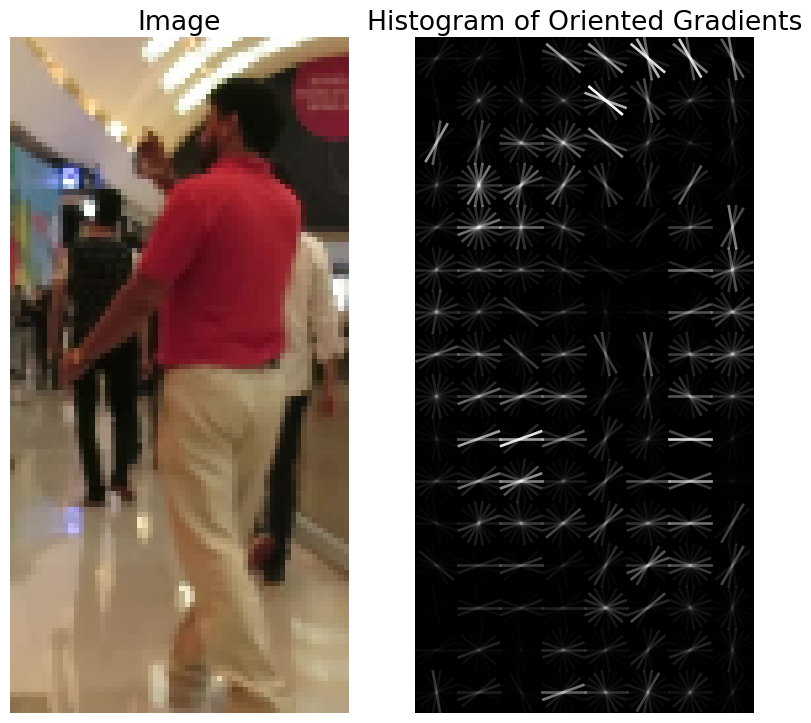

In [12]:
idx = 2829 #0
patch_idx = 0
block_size = 8
num_bins = 9

img = dataset_train[idx][1]["patches"][patch_idx]

gradient_norm, gradient_orientation = compute_image_gradient(transforms.functional.rgb_to_grayscale(img))
gradient_orientation[gradient_orientation >= 180.0] = gradient_orientation[gradient_orientation >= 180.0] - 180.0
hog_bins = fill_hog_bins(
    blockify_tensor(gradient_norm.squeeze(-3), block_size).flatten(0, -3).flatten(-2, -1),
    blockify_tensor(gradient_orientation.squeeze(-3), block_size).flatten(0, -3).flatten(-2, -1),
    num_bins,
)
hog_bins = torch.roll(hog_bins,num_bins//2, dims=-1)# in order to show lines along the edges instead of the gradient direction rotate by 90 degree
visualization.history_of_oriented_gradients(img, hog_bins.reshape(16, 8, num_bins))

For the first example in the dataset (`idx=0,patch_idx=0`), the visualization should look something like this:

![Example Visualization](./hog_visualization.png)

## Train a Classifier

In order to get the classifier part of an object detector capable of deciding whether in a given input patch an object is visible or not, we now train a small network, wich takes the handcrafted input features and computes a discision based on processing these features.
For training the binary classifier we use the binary cross entropy loss and the Adam optimizer.
During training, the accuracy $\frac{ TP+TN}{(TP+TN+FP+FN)}$ on the training set is reported for each training batch.
For evaluation we use the test set and compute the accuracy in the same way.


In [13]:
dataset_train = MOT16HoG(dataset_dir.joinpath("MOT16", "train"), transforms=obj_detect_transforms(train=False))
dataset_test = MOT16HoG(dataset_dir.joinpath("MOT16", "test"), random_offset=False, transforms=obj_detect_transforms(train=False))

In [14]:
num_epochs = 3
dataloader = DataLoader(dataset_train, batch_size=8)
model = Net(activation=torch.nn.ReLU(), input_size=3780, classes=1)

Store the model for submission. You can also test different architectures and revisit the trained models. Make sure that in the submission, the model.pt and the definition of the model in your python file correspond.

In [29]:
model.to(device)
loss = torch.nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1.0e-4)

train(dataloader, model, loss, optimizer, num_epochs, device)
torch.save(model.state_dict(), output_dir.joinpath("model.pt"))

  0%|          | 0/467 [00:00<?, ? batches/s]

Epoch 3: 100%|██████████| 467/467 [03:44<00:00,  2.08 batches/s, running loss=0.47, train accuracy=93.1, train precision=85.9, train recall=90.1]  


In [30]:
evaluate(DataLoader(dataset_test, batch_size=16), model, device)

100%|██████████| 100/100 [01:04<00:00,  1.54 batches/s, test accuracy=88.7, test precision=81.4, test recall=46.9]


As accuracy for unbalanced data is a limited measure for the performance, we should also focus on imporoving precision and recall.
Note that, in general, the accuracy of the whole object detector is calculated differently. The model is soving for the classification task only. In contrast, an object detector process an uncropped image. A 2-stage will first get object proposals (e.g. crops of the image) and then output a refined region of an object (regression) and its class (classification).

## Exercise Part IV - Sliding Window Detection

An object detector is more than just a classifier and has to solve the regression and object proposal task as well. Sliding window represents early and naive approaches to object detection. Given an image patches with a fixed resolution are extracted based on a sliding window manner. These patches are then classified as belonging to an object or not. Possible classifiers include template matching but also SVMs and neural networks. In this exercise, we will be using the classifier network trained in the last part of the exercise. Your task is to extract the image patches from a given image and then classify them and store the results in a heatmap.

As sliding window approaches are slow, a stride parameter - similar to CNNs - can be used to reduce the number of patches. Given an image of size $H \times W$ and a patch size of $H_p \times W_p$ the output heatmap has size
$$\lfloor \frac{H-(H_p-1)-1}{stride}+1 \rfloor, \lfloor \frac{W-(W_p-1)-1}{stride}+1\rfloor\,.$$

<div class="alert alert-info">
    <h3>Task: Sliding Window Detection</h3>
    <p>
    Go to <code> exercisecode/model/sliding_window_detection.py</code> and implement <code>sliding_window_detection</code>.
    </p>
</div>

<div class="alert alert-danger">
    <h3>Test: Sliding Window Detection</h3>
    <p> Run the following cell to execute the test case for the Sliding Window. As always the test are done with small dummy examples and do <b>not</b> guarantee correct implementation.</p>
</div>

In [15]:
_ = test_sliding_window_detection()

Congratulations: The output shape of sliding_window_detection with a stride of 1 is correct
Congratulations: The output shape of sliding_window_detection with a stride of 2 is correct
Congratulations: The output range of sliding_window_detection is correct
All tests of SlidingWindowDetectionTest passed. Tests passed: 3/3
Score: 100/100


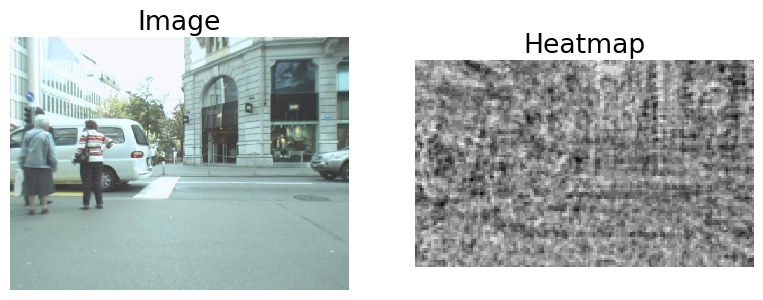

In [16]:
idx = 0
load_trained_model = False
if load_trained_model:
    model.load_state_dict(torch.load(output_dir.joinpath("model.pt")))
    model.to(device)
#img = dataset_train.get_whole_image(idx)
img = dataset_test.get_whole_image(idx)
patch_size = (128, 64)
heatmap = sliding_window_detection(img, model, patch_size, stride=4) # H_, W_
visualization.heatmap_objectness(img, heatmap)

## Exercise Part V - Non Maximum Suppression

So far the object detector creates a heatmap for a given input image. This heatmap consists of classification scores for each of the patches. Typically the classifier will create high classification scores for multiple bounding boxes that overlap with an object. However, it is desirable to keep only a single bounding box per object. Non Maximum Suppression (NMS) is a widely used post-processing algorithm to only the bounding box with the highest classification score within a certain vicinity. The pseudo-code for NMS is covered in lecture 2 as well as the exercise slides accompanying this exercise.

<div class="alert alert-info">
    <h3>Task: Non Maxmimum Suppression</h3>
    <p> Go to <code>model/nms.py</code> and implement <code> non_maximum_suppression</code>. Test yourself: How does a high threshold influence the precision and the recall of the object detector? </p>
</div>

<div class="alert alert-danger">
    <h3>Test: Non Maxmimum Suppression</h3>
    <p> Run the following cell to execute the test case for the Non Maximum Suppression. As always the test are done with small dummy examples and do <b>not</b> guarantee correct implementation.</p>
</div>

In [34]:
_ = test_non_maximum_suppression()

The output shape of test case 1 is incorrect (expected torch.Size([16, 4]), got torch.Size([31, 4])).
The output shape of test case 1 is incorrect (expected torch.Size([24, 4]), got torch.Size([51, 4])).
The output shape of test case 1 is incorrect (expected torch.Size([73, 4]), got torch.Size([84, 4])).
Congratulations: Test case 1 ran successfully
Some tests of NMSTest failed. Tests passed: 1/4
Score: 25/100


In [ ]:
idx = 0
block_size = 8
num_bins = 9
patch_size = (128, 64)
pyramid_levels = [0, 1]
strides = [8, 4]

img = dataset_test.get_whole_image(idx)
results = []
for level, stride in zip(pyramid_levels, strides):
    scale = 2**level
    img_pyramid = transforms.functional.resize(img, [img.shape[-2] // scale, img.shape[-1] // scale])

    heatmap = sliding_window_detection(img_pyramid, model, patch_size, stride) # H_, W_
    result = extract_bbox_from_heatmap(heatmap, 0.5, patch_size, scale, stride )# (B,4), (B,) or None,None
    results.append(result) 

bboxes = torch.cat([result[0] for result in results if result[0] is not None], dim=0) #B*num_levels*num_strides,4
scores = torch.cat([result[1] for result in results if result[1] is not None], dim=0) #B*num_levels*num_strides
print(bboxes.shape)

In [ ]:
visualization.bboxes(img, bboxes)

In [ ]:
nms_bboxes = non_maximum_suppression(bboxes, scores, 0.2)

In [ ]:
visualization.bboxes(img, nms_bboxes)

Now you are done. You can zip the entire folder using the subsequent command.

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise01')

## Exercise Part VI - Testing an SOTA object detector

For comparison, we provide you with a SOTA object detector pretrained on the MOT challenge training set, which will also be used in the upcoming exercise.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) [1] with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

[1] [Ren et al. Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks, NeurIPS 2015](https://arxiv.org/abs/1506.01497)

In [ ]:

from exercise_code import (
    FRCNN_FPN,
    MOT16ObjDetect,
    get_obj_detections,
    eval_obj_detect_fixIoU
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
model_file = output_dir.joinpath('faster_rcnn_fpn.model')
nms_thresh = 0.3
model_FRCNN = FRCNN_FPN(num_classes=2, nms_thresh=nms_thresh)
state_dict = torch.load(model_file, map_location=lambda storage, loc: storage)
model_FRCNN.load_state_dict(state_dict)

In [ ]:
model_FRCNN.eval()
model_FRCNN.to(device)

In [ ]:
idx = 150
block_size = 8
num_bins = 9
patch_size = (128, 64)
pyramid_levels = [0, 1]
strides = [4, 4]

img = dataset_test.get_whole_image(idx)

with torch.no_grad():
    preds = model_FRCNN(img[None])[0]

bboxes = preds["boxes"] #B*num_levels*num_strides,4
scores = preds["scores"] #B*num_levels*num_strides
print(bboxes.shape)

As you noticed by running the above cell, in contrast to the previous historic approach the Faster R-CNN forward pass takes only a fraction of the time, which was needed to slide over the entire image and performing classification of all the object proposals.

In [ ]:
visualization.bboxes(img, bboxes)

For testing the performance of the object detector, we load the `dataset_test_objdetect` and run the object detector for `max_num_imgs` images. The results will be used to evaluate the object detector.

In [ ]:
dataset_test_objdetect = MOT16ObjDetect(dataset_dir.joinpath('MOT16', 'train'),
                              obj_detect_transforms(train=False))
data_loader = DataLoader(dataset_test_objdetect, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
results = get_obj_detections(model_FRCNN, data_loader, max_num_imgs = 10)

In order to calculate the precision and recall of the object detection we have to match predicted bounding boxes with ground truth bounding boxes. A bounding box prediction is marked as correct, if the everlap with any gound truth annotation is bigger than `IoU_th`. Also we can consider only object detections that have a higher confidence than `conf_th`. Run the evaluation below for different values of the `conf_th`. You will see that these values form the Precision-Recall-Curve. The detector will not be able to detect all objects, even with a very low confidence threshold. However, with a very high threshold, all detections will be correct.

In [ ]:
prec, rec = eval_obj_detect_fixIoU(dataset_test_objdetect, results, IoU_th=0.6, conf_th=0.97, verbose=True)
print(f"Prec: {prec} Rec: {rec}")

You tested the evaluation by running it for different values for `conf_th`. In order to evaluate the object detector, we have to build the Precision-Recall-Curve with varying confidence thresholds to compute the Average Precision, which is the area under the Precision-Recall-Curve (AuC).
$$AP = \int_0^1 prec(rec) d(rec)$$

Furthermore, one can find a good setting for the object detection threshold by determining the highest F1-Score for different values of the confidence. The F1-Score is high, if Precision and Recall are high.
$$F1 Score = \frac{2 \cdot prec \cdot rec}{prec + rec}$$

Think about the following and fill in the missing value (not relevant for submission):

The $mAP$ also considers the dependency on the setting of the IoU threshold. Small IoU thresholds result in a (higher/lower) number of TP predictions. Therefore the recall=TP/P of the detector will be (higher/lower) for smaller IoU thresholds.

![mAP Visualization](./mAP.png)

The mean Average Precision will then calculate the mean of all the AUCs, for a predefined set of IoU thresholds.
$$mAP = \frac{1}{K} \sum_k AP_{IoU=k}$$